In [32]:
import torch
from einops import rearrange, einsum, reduce
import matplotlib.pyplot as plt
import json

In [23]:
potential_probes = torch.load('/workspace/refusal-ablation-misalignment/gemma-2-2b-it-potential-probes.pt').to('cuda')
potential_probes /= potential_probes.norm(dim=-1, keepdim=True)


In [24]:
dot_products = einsum(potential_probes, potential_probes, 'l1 p1 d_model, l2 p2 d_model -> l1 l2 p1 p2')
# %%


In [25]:
dot_products

tensor([[[[ 1.0000e+00,  1.6631e-01,  3.9777e-01,  9.3136e-02,  1.7183e-01],
          [ 1.6631e-01,  1.0000e+00,  2.8982e-01,  3.0015e-01,  9.4015e-01],
          [ 3.9777e-01,  2.8982e-01,  1.0000e+00,  2.7892e-01,  3.0462e-01],
          [ 9.3136e-02,  3.0015e-01,  2.7892e-01,  1.0000e+00,  2.9276e-01],
          [ 1.7183e-01,  9.4015e-01,  3.0462e-01,  2.9276e-01,  1.0000e+00]],

         [[ 7.6003e-01,  1.7955e-01,  2.7041e-01,  7.3547e-02,  9.8634e-02],
          [ 2.8754e-01,  4.8587e-01,  3.3326e-01,  1.6736e-01,  3.7317e-01],
          [ 3.0068e-01,  2.4007e-01,  6.2456e-01,  1.9187e-01,  2.1956e-01],
          [ 8.0614e-02,  2.2616e-01,  2.2705e-01,  4.2515e-01,  2.2617e-01],
          [ 2.6106e-01,  4.5408e-01,  3.1321e-01,  1.6995e-01,  3.8620e-01]],

         [[ 6.0576e-01,  1.5192e-01,  2.0709e-01,  7.2124e-02,  5.6904e-02],
          [ 1.8455e-01,  3.1063e-01,  2.9287e-01,  1.2087e-01,  1.2877e-01],
          [ 1.8507e-01,  1.4432e-01,  4.6908e-01,  1.5675e-01,  1.6613e-

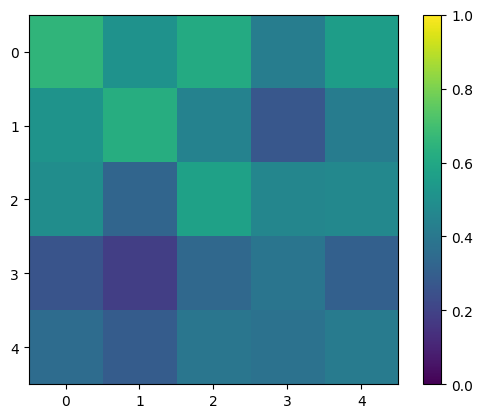

In [31]:
plt.imshow(dot_products[15, 10].cpu().numpy(), vmin=0, vmax=1)
plt.colorbar()

In [51]:
n_layers = 26
n_positions = 5
scores = torch.zeros(n_layers, n_positions)
for layer in range(n_layers):
    for position in range(n_positions):
        with open(f'/workspace/refusal-ablation-misalignment/generations/gemma-2-2b-it-harmful-val-generations-{layer}-{position}.json', 'r') as f:
            generations = json.load(f)
            refusal_rate = torch.tensor(['\nI cannot' in x.split('<start_of_turn>')[-1] for x in generations],dtype = torch.float32).mean().item()
            scores[layer, position] = refusal_rate

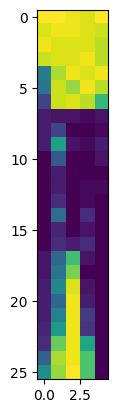

In [53]:
plt.imshow(scores.cpu().numpy())

In [61]:
interesting_idxes = [(l.item(), p.item()) for l, p in zip(*torch.where(scores < 0.1))]

In [66]:
for l1, p1 in interesting_idxes:
    for l2, p2 in interesting_idxes:
        if l1 == l2 and p1 == p2:
            continue
        else:
            if dot_products[l1, l2, p1, p2].abs() <0.01:
                print(f'l1: {l1}, p1: {p1}, l2: {l2}, p2: {p2}')
# %%



l1: 7, p1: 4, l2: 18, p2: 3
l1: 7, p1: 4, l2: 20, p2: 3
l1: 18, p1: 3, l2: 7, p2: 4
l1: 20, p1: 3, l2: 7, p2: 4
